In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import copy
from os import path

from pprint import pprint

from versuchung.search import *

import sys
import bench

from versuchung.tex import DatarefDict

plt.style.use('bmh')
plt.rcParams["axes.labelcolor"] = "black"
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["xtick.color"] = "black"
plt.rcParams["ytick.color"] = "black"
plt.rcParams["xtick.labelcolor"] = "black"
plt.rcParams["ytick.labelcolor"] = "black"
plt.rcParams["axes.labelcolor"] = "black"
plt.rcParams['axes.facecolor'] = '#F5F5F5'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = '0.8'

exps = {
    'baseline':
    {'query': { 'scope': 'nil',
                'ld_preload': '' }},
    'pac-pl-char':
    {'query': { 'scope': 'char',
                'ld_preload': '/root/pac-sw/pac-pl/pac-pl.so' }},
    'pac-pl-strong':
    {'query': { 'scope': 'strong',
                'ld_preload': '/root/pac-sw/pac-pl/pac-pl.so' }},
    'pac-pl-all':
    {'query': { 'scope': 'all',
                'ld_preload': '/root/pac-sw/pac-pl/pac-pl.so' }},
    'pac-pl-libkpac':
    {'query': { 'scope': 'nil',
                'ld_preload': '/root/pac-sw/pac-pl/pac-pl.so /root/pac-sw/libkpac/libkpac-pac-pl.so',
                'libkpac_mode': 'kpac-svc' }},
    'svc-char':
    {'query': { 'scope': 'char',
                'variant': 'syscall',
                'ld_preload': '' }},
    'svc-strong':
    {'query': { 'scope': 'strong',
                'variant': 'syscall',
                'ld_preload': '' }},
    'svc-all':
    {'query': { 'scope': 'all',
                'variant': 'syscall',
                'ld_preload': '' }},
    'svc-libkpac':
    {'query': { 'scope': 'nil',
                'ld_preload': '/root/pac-sw/libkpac/libkpac-kpacd.so',
                'libkpac_mode': 'svc-only' }},
    'kpacd-char':
    {'query': { 'scope': 'char',
                'variant': 'kpacd',
                'ld_preload': '' }},
    'kpacd-strong':
    {'query': { 'scope': 'strong',
                'variant': 'kpacd',
                'ld_preload': '' }},
    'kpacd-all':
    {'query': { 'scope': 'all',
                'variant': 'kpacd',
                'ld_preload': '' }},
    'kpacd-libkpac':
    {'query': { 'scope': 'nil',
                'ld_preload': '/root/pac-sw/libkpac/libkpac-kpacd.so',
                'libkpac_mode': 'kpac-svc' }},
}

datapath = "cortexsuite/zynqmp-136/"
for k in exps:
    exps[k]['exp'] = search_experiment(bench.Bench, datapath, exps[k]['query'])

for k, v in exps.items():
    print(f'{k}: {v["exp"].path}')
    pprint(v["exp"].metadata)


baseline: /srv/scratch/ill.ostapyshyn/proj/kpac/rtas-pac/data/bench/cortexsuite/zynqmp-136/Bench-1a35ed26e30c0a470f8561d311413ff8
{'arch': 'aarch64',
 'backend': 'siphash',
 'cflags': '-O2',
 'cpumasks': '',
 'date-end': '2024-02-29 20:50:07.216711',
 'date-start': '2024-02-29 20:15:52.745354',
 'experiment-hash': '1a35ed26e30c0a470f8561d311413ff8',
 'experiment-name': 'Bench',
 'experiment-version': 1,
 'host': 'zynqmp',
 'kernel': 'Linux 6.1.0-kpac-xilinx-nop+ #95 SMP Thu Feb 29 07:48:23 CET 2024',
 'ld_preload': '',
 'libkpac_mode': '',
 'scope': 'nil',
 'suite': 'cortexsuite',
 'variant': 'syscall'}
pac-pl-char: /srv/scratch/ill.ostapyshyn/proj/kpac/rtas-pac/data/bench/cortexsuite/zynqmp-136/Bench-87a983f9787d60aea9fa699e5e178d0e
{'arch': 'aarch64',
 'backend': 'siphash',
 'cflags': '-O2',
 'cpumasks': '',
 'date-end': '2024-02-29 23:15:30.183031',
 'date-start': '2024-02-29 22:40:34.363680',
 'experiment-hash': '87a983f9787d60aea9fa699e5e178d0e',
 'experiment-name': 'Bench',
 'exp

In [2]:
# Construct table [approach][benchmark] = average runtime
runtime = {}

libkpac = {'times': {}, 'times_nolib': {}, 'pac': {}, 'aut': {}} # value, approach, benchmark
sizes = {}
for k, v in exps.items(): 
    pac_raw = dict(np.load(v['exp'].o.pac.path))
    runtime[k] = pac_raw

    for a in libkpac.keys():
        libkpac[a][k] = {}

    sizes[k] = {}

    benchmarks = list(pac_raw.keys())
    for b in benchmarks:

        with open(os.path.join(v['exp'].o.log.path, b, "binary_size")) as f:
            csvreader = csv.reader(f, delimiter=' ')

            #print(list(csvreader))
            sizes[k][b] = 0
            for row in csvreader:
                row = [x for x in row if x]
                if row[0] == '.text':
                    sizes[k][b] = int(row[1])
                    break

            #sizes[k][b] = int({k.strip(): v for k, v in dict(list(csvreader)[0]).items()}['text'])
        
        libkpac["times"][k][b] = np.array([float(0)] * len(pac_raw[b]))
        libkpac["times_nolib"][k][b] = np.array([float(0)] * len(pac_raw[b]))
        libkpac['pac'][k][b] = (0, 0)
        libkpac['aut'][k][b] = (0, 0)
        
        if 'libkpac' in v['exp'].metadata['ld_preload']:
            directory = os.path.join(v['exp'].o.log.path, b, "libkpac")
            for i in range(len(pac_raw[b])):
                with open(os.path.join(directory, str(i) + '.csv')) as f:
                    total = { 'time': 0,
                              'pac_total': 0,
                              'pac_patched': 0,
                              'aut_total': 0,
                              'aut_patched': 0 }
                    
                    reader = list(csv.reader(f, delimiter=','))
                    for row in reader:
                        for j, a in enumerate(total.keys()):
                            total[a] = total[a] + float(row[j+1])
                        #break

                    libkpac['times_nolib'][k][b][i] = reader[0][1]
                    libkpac['times'][k][b][i] = total['time']
                    libkpac['pac'][k][b] = (total['pac_total'], total['pac_patched'])
                    libkpac['aut'][k][b] = (total['aut_total'], total['aut_patched'])

runtime = pd.DataFrame(runtime)
for k,v in libkpac.items():
    libkpac[k] = pd.DataFrame(libkpac[k])

# Subtract setup time for libkpac
runtime = runtime - libkpac['times']

std = runtime.map(np.std)
runtime = runtime.map(np.mean)
libkpac['times'] = libkpac['times'].map(np.mean)
libkpac['times_nolib'] = libkpac['times_nolib'].map(np.mean)

rstd = std/runtime
print('rstd:')
display(rstd*100)

display(runtime)

sizes = pd.DataFrame(sizes)
display(sizes)


rstd:


,baseline,pac-pl-char,pac-pl-strong,pac-pl-all,pac-pl-libkpac,svc-char,svc-strong,svc-all,svc-libkpac,kpacd-char,kpacd-strong,kpacd-all,kpacd-libkpac
liblinear,0.176996,0.236090,0.174409,0.213119,0.182309,0.258780,0.188788,0.227242,0.265622,0.157066,0.246427,0.191303,0.211567
kmeans,0.074308,0.092947,0.066950,0.061111,0.096299,0.070843,0.114597,0.116024,0.080340,0.086491,0.093700,0.113741,0.069446
spectral,0.158935,0.157625,0.205471,0.132496,0.108954,0.193352,0.164648,0.202214,0.124491,0.155062,0.147586,0.132481,0.176634
lda,0.592438,0.117956,0.107887,0.022923,0.042183,0.377849,0.454240,0.011923,0.017576,0.429282,0.090755,0.029825,0.030992
motion-estimation,0.019993,0.016681,0.019635,0.014753,0.631825,0.009606,0.020231,0.025010,0.025160,0.017176,0.015472,0.016818,0.018627
pca,0.426197,0.520760,0.361777,0.326724,0.674321,0.405064,0.427350,0.338841,0.475470,0.330044,0.419358,0.488867,0.358047
rbm,0.273741,0.189358,0.308716,0.306366,0.240825,0.376147,0.185198,0.192015,0.354008,0.342624,0.277782,0.198781,0.319148
sphinx,0.028286,0.034788,0.025266,0.018726,1.956192,0.021694,0.033882,0.009884,0.015192,0.035396,0.059723,0.031831,0.026109
srr,0.192785,0.156009,0.132544,0.212499,0.243671,0.240284,0.248732,0.128968,0.207997,0.136087,0.208517,0.072566,0.140503
svd3,0.740001,0.940982,1.377825,0.709479,0.870684,0.328433,0.495052,0.332512,0.466711,0.903734,0.803168,0.669361,0.477715


,baseline,pac-pl-char,pac-pl-strong,pac-pl-all,pac-pl-libkpac,svc-char,svc-strong,svc-all,svc-libkpac,kpacd-char,kpacd-strong,kpacd-all,kpacd-libkpac
liblinear,25.747017,25.760809,25.752661,25.767800,25.778203,25.748957,25.741909,25.830244,25.845458,25.681620,25.681903,25.649113,25.692257
kmeans,33.744293,33.728053,33.722414,33.715221,33.768875,33.781207,33.779680,33.765549,33.731577,33.661695,33.658818,33.656087,33.608238
spectral,6.960159,6.970631,6.972762,6.975801,6.991109,6.971372,6.970416,6.966865,6.981107,6.927523,6.926485,6.922323,6.946423
lda,18.251007,18.396892,18.391013,79.674008,137.436736,19.014077,19.018262,317.142295,316.975417,18.281116,18.250268,43.437625,98.081555
motion-estimation,9.423663,9.664813,9.762392,9.860633,9.659990,9.661547,10.143555,10.626761,10.412472,9.632848,9.678748,9.719490,9.501340
pca,3.289701,3.290682,3.294312,3.295443,3.315881,3.288258,3.289595,3.290879,3.322510,3.275319,3.273269,3.281179,3.306109
rbm,21.003723,21.060562,22.749833,24.494850,24.618664,21.068669,29.498037,37.727003,37.836522,20.878332,21.541492,22.255610,22.436957
sphinx,12.387791,15.601728,18.378422,39.760835,44.630088,27.871577,41.415314,145.953480,141.549655,13.730528,14.811904,23.123694,28.443043
srr,29.123873,29.343576,30.231201,30.239705,32.341257,29.298526,33.827140,33.875661,33.805748,29.250988,29.661021,29.660313,31.579099
svd3,14.548136,14.575728,14.589016,14.901865,14.959878,14.523216,14.577974,16.601418,16.597867,14.534649,14.560174,14.658026,14.670107


,baseline,pac-pl-char,pac-pl-strong,pac-pl-all,pac-pl-libkpac,svc-char,svc-strong,svc-all,svc-libkpac,kpacd-char,kpacd-strong,kpacd-all,kpacd-libkpac
liblinear,38392,38880,39552,41344,38808,38624,38800,39056,38808,39104,40224,43216,38808
kmeans,2060,2156,2156,2252,2140,2044,2044,2060,2140,2252,2252,2412,2140
spectral,5820,5964,5964,6300,5852,5852,5852,5932,5852,5996,5996,6556,5852
lda,9100,9436,9548,10396,9324,9164,9180,13468,9324,9660,9804,11212,9324
motion-estimation,4060,4076,4284,4524,4108,4044,4076,4108,4108,4108,4412,4812,4108
pca,5516,5532,5532,5932,5532,5532,5532,5564,5532,5532,5532,6156,5532
rbm,3500,3356,3660,3996,3548,3356,3452,3468,3548,3356,3884,4444,3548
sphinx,285672,284384,289104,316656,291480,280848,281600,285484,291480,287312,295200,334352,291480
srr,12636,12828,13020,13692,12748,12796,12812,12908,12748,12860,13180,14316,12748
svd3,25380,25740,25836,28732,25752,25544,25576,25944,25752,25900,26060,30844,25752


In [3]:
# Divide runtimes by baseline yielding overhead
overhead = runtime.iloc[:,1:].div(runtime['baseline'], axis=0)

#display(rstd.iloc[:,1:]*rstd.iloc[:,1:])
#display(rstd['baseline']*rstd['baseline'])
overhead_rstd = (rstd.iloc[:,1:]*rstd.iloc[:,1:]).add(rstd['baseline']*rstd['baseline'], axis=0).map(np.sqrt)
display(overhead_rstd*100)

# Clamp values under 1 to 1
overhead = overhead.where(overhead > 1, other=1)
overhead = overhead.sort_values(by='svc-all',ascending=False)
display(overhead)

oh_export = overhead.copy()
oh_export['baseline'] = runtime['baseline']
display(oh_export)

dref_file = "overheads.tex"
try:
    os.unlink(dref_file)
except OSError:
    pass

dref_out = DatarefDict(dref_file)
dref_out.pandas(oh_export)
dref_out.flush()

# Get min, average and max over benchmarks
stats = overhead.aggregate(func=['min','mean', 'max'],axis=0).T
stats['geom'] = np.power(overhead.T.iloc[:].prod(axis=1),1.0/overhead.index.size)

# sqrt of average of variances
stats['rstd'] = overhead_rstd.T.iloc[:].apply(lambda x: np.sqrt(np.mean(x*x)), axis=1)
display(stats)

dref_file = "overhead_stats.tex"
try:
    os.unlink(dref_file)
except OSError:
    pass

dref_out = DatarefDict(dref_file)
dref_out.pandas(stats)
dref_out.flush()

,pac-pl-char,pac-pl-strong,pac-pl-all,pac-pl-libkpac,svc-char,svc-strong,svc-all,svc-libkpac,kpacd-char,kpacd-strong,kpacd-all,kpacd-libkpac
liblinear,0.295069,0.248487,0.277033,0.254095,0.313520,0.258783,0.288039,0.319191,0.236638,0.303404,0.260623,0.275841
kmeans,0.119000,0.100020,0.096210,0.121635,0.102666,0.136580,0.137779,0.109436,0.114028,0.119588,0.135863,0.101708
spectral,0.223844,0.259767,0.206919,0.192695,0.250291,0.228843,0.257199,0.201887,0.222047,0.216892,0.206910,0.237613
lda,0.604067,0.602182,0.592882,0.593938,0.702675,0.746537,0.592558,0.592699,0.731619,0.599349,0.593189,0.593248
motion-estimation,0.026038,0.028022,0.024847,0.632141,0.022181,0.028443,0.032019,0.032136,0.026358,0.025280,0.026126,0.027325
pca,0.672930,0.559040,0.537022,0.797717,0.587980,0.603549,0.544479,0.638526,0.539048,0.597917,0.648564,0.556634
rbm,0.332852,0.412601,0.410846,0.364597,0.465210,0.330503,0.334371,0.447500,0.438549,0.389996,0.338302,0.420463
sphinx,0.044836,0.037927,0.033922,1.956397,0.035647,0.044137,0.029963,0.032107,0.045309,0.066083,0.042583,0.038493
srr,0.248002,0.233953,0.286918,0.310712,0.308063,0.314696,0.231946,0.283600,0.235979,0.283981,0.205990,0.238552
svd3,1.197100,1.563970,1.025164,1.142669,0.809611,0.890325,0.811274,0.874883,1.168048,1.092100,0.997821,0.880803


,pac-pl-char,pac-pl-strong,pac-pl-all,pac-pl-libkpac,svc-char,svc-strong,svc-all,svc-libkpac,kpacd-char,kpacd-strong,kpacd-all,kpacd-libkpac
lda,1.007993,1.007671,4.365458,7.530365,1.041810,1.042039,17.376701,17.367558,1.001650,1.000000,2.380013,5.374035
sphinx,1.259444,1.483592,3.209679,3.602748,2.249923,3.343236,11.782042,11.426545,1.108392,1.195686,1.866652,2.296054
rbm,1.002706,1.083133,1.166215,1.172110,1.003092,1.404419,1.796206,1.801420,1.000000,1.025604,1.059603,1.068237
srr,1.007544,1.038021,1.038313,1.110472,1.005997,1.161492,1.163158,1.160757,1.004365,1.018444,1.018419,1.084303
svd3,1.001897,1.002810,1.024314,1.028302,1.000000,1.002051,1.141137,1.140893,1.000000,1.000827,1.007554,1.008384
motion-estimation,1.025590,1.035945,1.046369,1.025078,1.025243,1.076392,1.127668,1.104928,1.022198,1.027069,1.031392,1.008243
liblinear,1.000536,1.000219,1.000807,1.001211,1.000075,1.000000,1.003233,1.003823,1.000000,1.000000,1.000000,1.000000
spectral,1.001505,1.001811,1.002247,1.004447,1.001611,1.001474,1.000963,1.003010,1.000000,1.000000,1.000000,1.000000
kmeans,1.000000,1.000000,1.000000,1.000728,1.001094,1.001049,1.000630,1.000000,1.000000,1.000000,1.000000,1.000000
pca,1.000298,1.001401,1.001745,1.007958,1.000000,1.000000,1.000358,1.009973,1.000000,1.000000,1.000000,1.004988


,pac-pl-char,pac-pl-strong,pac-pl-all,pac-pl-libkpac,svc-char,svc-strong,svc-all,svc-libkpac,kpacd-char,kpacd-strong,kpacd-all,kpacd-libkpac,baseline
lda,1.007993,1.007671,4.365458,7.530365,1.041810,1.042039,17.376701,17.367558,1.001650,1.000000,2.380013,5.374035,18.251007
sphinx,1.259444,1.483592,3.209679,3.602748,2.249923,3.343236,11.782042,11.426545,1.108392,1.195686,1.866652,2.296054,12.387791
rbm,1.002706,1.083133,1.166215,1.172110,1.003092,1.404419,1.796206,1.801420,1.000000,1.025604,1.059603,1.068237,21.003723
srr,1.007544,1.038021,1.038313,1.110472,1.005997,1.161492,1.163158,1.160757,1.004365,1.018444,1.018419,1.084303,29.123873
svd3,1.001897,1.002810,1.024314,1.028302,1.000000,1.002051,1.141137,1.140893,1.000000,1.000827,1.007554,1.008384,14.548136
motion-estimation,1.025590,1.035945,1.046369,1.025078,1.025243,1.076392,1.127668,1.104928,1.022198,1.027069,1.031392,1.008243,9.423663
liblinear,1.000536,1.000219,1.000807,1.001211,1.000075,1.000000,1.003233,1.003823,1.000000,1.000000,1.000000,1.000000,25.747017
spectral,1.001505,1.001811,1.002247,1.004447,1.001611,1.001474,1.000963,1.003010,1.000000,1.000000,1.000000,1.000000,6.960159
kmeans,1.000000,1.000000,1.000000,1.000728,1.001094,1.001049,1.000630,1.000000,1.000000,1.000000,1.000000,1.000000,33.744293
pca,1.000298,1.001401,1.001745,1.007958,1.000000,1.000000,1.000358,1.009973,1.000000,1.000000,1.000000,1.004988,3.289701


,min,mean,max,geom,rstd
pac-pl-char,1.000000,1.030751,1.259444,1.028226,0.005077
pac-pl-strong,1.000000,1.065460,1.483592,1.057686,0.005906
pac-pl-all,1.000000,1.585515,4.365458,1.337149,0.004553
pac-pl-libkpac,1.000728,1.948342,7.530365,1.437810,0.008287
svc-char,1.000000,1.132885,2.249923,1.092931,0.004449
svc-strong,1.000000,1.303215,3.343236,1.199090,0.004542
svc-all,1.000358,3.839210,17.376701,1.880594,0.004051
svc-libkpac,1.000000,3.801891,17.367558,1.873209,0.004429
kpacd-char,1.000000,1.013660,1.108392,1.013173,0.005059
kpacd-strong,1.000000,1.026763,1.195686,1.025296,0.004796


,min,mean,max,geom,rstd,std
char,1.000000,1.030751,1.259444,1.028226,0.005077,0.005220
strong,1.000000,1.065460,1.483592,1.057686,0.005906,0.006246
all,1.000000,1.585515,4.365458,1.337149,0.004553,0.006087
libkpac,1.000728,1.948342,7.530365,1.437810,0.008287,0.011915
char,1.000000,1.132885,2.249923,1.092931,0.004449,0.004863
strong,1.000000,1.303215,3.343236,1.199090,0.004542,0.005447
all,1.000358,3.839210,17.376701,1.880594,0.004051,0.007619
libkpac,1.000000,3.801891,17.367558,1.873209,0.004429,0.008297
char,1.000000,1.013660,1.108392,1.013173,0.005059,0.005126
strong,1.000000,1.026763,1.195686,1.025296,0.004796,0.004918


[1.  1.2 1.4 1.6 1.8 2. ]


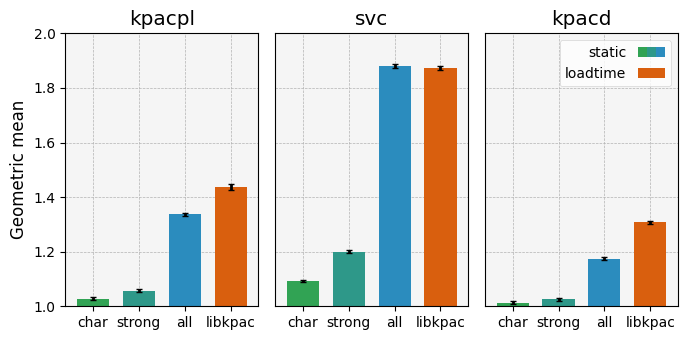

In [7]:
data = stats.reset_index()

# Separate by communication interface and instrumentation approach
data['approach'] = data['index'].map(lambda x: x[:x.rfind('-')])
data['variant'] = data['index'].map(lambda x: x[x.rfind('-')+1:])

data['std'] = data['rstd']*data['geom']

# Keep only average for reasonable scale
#data = data.drop('max', axis=1)
#data = data.drop('min', axis=1)
#data = data.drop('geom', axis=1)
#data = data.drop('rstd', axis=1)

data = data.set_index('variant')
data = data.drop('approach',axis=1)
data = data.drop('index', axis=1)
data.index.name = None
fig, axs = plt.subplots(1,3,width_ratios=[4,4,4],figsize=(7,3.5))

display(data)

tickheight = 2.1
yticks = np.arange(1.0,tickheight,0.2)
print(yticks)

colors = ['#31a354','#2e9889','#2B8CBE','#D95F0E']
#colors = ['#2B8CBE','#2B8CBE','#2B8CBE','#D95F0E']

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import ListedColormap

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent], 
                          width / self.num_stripes, 
                          height, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

llabels=["static", "loadtime"]
lcolors = [ListedColormap(['#31a354','#2e9889','#2B8CBE']), ListedColormap(['#D95F0E'])]
lhandles = [Rectangle((0, 0), 1, 1) for _ in lcolors]
handler_map = dict(zip(lhandles, [HandlerColormap(cm, num_stripes=len(cm.colors)) for cm in lcolors]))

#import matplotlib.patches as mpatches
#char = mpatches.Patch(color=colors[0], label='')
#strong = mpatches.Patch(color=colors[1], label='static')
#all = mpatches.Patch(color=colors[2], label='')
#libkpac = mpatches.Patch(color=colors[3], label='libkpac')

# Keep yticks only for the leftmost plot
df = pd.DataFrame(data.iloc[0:4]).T
ax = df.loc['geom'].plot.bar(ax=axs[0],width=0.7,ylabel="Geometric mean", title="kpacpl",rot=0, color=colors,stacked=True,yerr=df.loc['std'], capsize=2)
ax.yaxis.set_ticks(yticks)
ax.set_axisbelow(True)
ax.set_xticklabels(df.columns)
ax.grid(True)
ax.set_ylim(yticks[0], yticks[-1])

df = pd.DataFrame(data.iloc[4:8]).T
ax = df.loc['geom'].plot.bar(ax=axs[1],width=0.7, title="svc",rot=0, color=colors,stacked=True, yerr=df.loc['std'], capsize=2)
ax.yaxis.set_ticks(yticks)
ax.set_yticklabels([])
ax.set_xticklabels(df.columns)
ax.yaxis.set_ticks_position('none')
ax.set_axisbelow(True)
ax.grid(True)
ax.set_ylim(yticks[0], yticks[-1])

df = pd.DataFrame(data.iloc[8:]).T
ax = df.loc['geom'].plot.bar(ax=axs[2],width=0.7, title="kpacd",rot=0, color=colors,stacked=True, yerr=df.loc['std'], capsize=2)
ax.yaxis.set_ticks(yticks)
ax.set_yticklabels([])
ax.set_xticklabels(df.columns)
ax.yaxis.set_ticks_position('none')
ax.set_axisbelow(True)
ax.legend(handles=lhandles, 
           labels=llabels, 
           handler_map=handler_map,
         markerfirst=False)
#ax.legend(handles=[char,strong,all,libkpacd], loc=2)
ax.grid(True)
ax.set_ylim(yticks[0], yticks[-1])

plt.tight_layout()
plt.savefig("../../fig/cortexbench_overhead.pdf",bbox_inches='tight')

In [5]:
# data = stats.reset_index()
# data.loc[2.5] = '',0,0,0
# data.loc[6.5] = '',0,0,0
# data = data.sort_index().reset_index(drop=True)
# display(data)
# ax = data.plot.bar(figsize=(8,4),ylabel="Overhead ",width=0.7)
# ax.set_xticklabels(data['index'])
# ax.yaxis.set_ticks(np.arange(0,18,1))
# foo = np.delete(ax.get_xticks(),[3,8])
# ax.xaxis.set_ticks(foo)
# ax.set_axisbelow(True)
# ax.grid(True)

# plt.tight_layout()

In [6]:
# Export libkpac statistics

libkpac_table = pd.DataFrame()
libkpac_table['text'] = sizes['kpacd-libkpac']
libkpac_table['setup/svc'] = libkpac['times']['svc-libkpac']
libkpac_table['setup/kpacd'] = libkpac['times']['kpacd-libkpac']

libkpac_table['setup_nl/svc'] = libkpac['times_nolib']['svc-libkpac']
libkpac_table['setup_nl/kpacd'] = libkpac['times_nolib']['kpacd-libkpac']

libkpac_table['pac/total'] = libkpac['pac']['kpacd-libkpac'].apply(lambda x: x[0])
libkpac_table['pac/patched'] = libkpac['pac']['kpacd-libkpac'].apply(lambda x: x[1])
libkpac_table['aut/total'] = libkpac['aut']['kpacd-libkpac'].apply(lambda x: x[0])
libkpac_table['aut/patched'] = libkpac['aut']['kpacd-libkpac'].apply(lambda x: x[1])

libkpac_copy = libkpac_table.copy()
libkpac_table.loc['Total'] = libkpac_copy.sum()
libkpac_table.loc['Average'] = libkpac_copy.mean()
display(libkpac_table)

dref_file = "libkpac_data.tex"
try:
    os.unlink(dref_file)
except OSError:
    pass

dref_out = DatarefDict(dref_file)
dref_out.pandas(libkpac_table)
dref_out.flush()

,text,setup/svc,setup/kpacd,setup_nl/svc,setup_nl/kpacd,pac/total,pac/patched,aut/total,aut/patched
liblinear,38808.0,0.009228,0.009244,0.001060,0.001262,56.0,52.0,72.0,67.0
kmeans,2140.0,0.005947,0.005996,0.000286,0.000473,4.0,3.0,4.0,3.0
spectral,5852.0,0.008352,0.008539,0.000377,0.000559,9.0,8.0,9.0,9.0
lda,9324.0,0.008492,0.008526,0.000455,0.000640,26.0,25.0,28.0,28.0
motion-estimation,4108.0,0.005867,0.006029,0.000300,0.000491,9.0,8.0,13.0,12.0
pca,5532.0,0.008317,0.008476,0.000293,0.000496,9.0,9.0,9.0,9.0
rbm,3548.0,0.008265,0.008407,0.000288,0.000469,13.0,9.0,13.0,9.0
sphinx,291480.0,0.015970,0.016167,0.007928,0.008275,640.0,627.0,915.0,902.0
srr,12748.0,0.006023,0.006185,0.000490,0.000654,18.0,12.0,21.0,18.0
svd3,25752.0,0.008834,0.009145,0.000872,0.001049,67.0,67.0,78.0,78.0
